In [7]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt

# Problem Methodology

* Our objective is to predict the residential electric consumption in the U.S in 2009.
* This is a regression problem, and the high level approach to this problem could be the following steps: 
    1. Data exploration/Data cleaning
    2. Data engineering/wrangling
    3. Data analysis/Modeling
    4. Data evaluation/validation


# 1. Data exploration/Data cleaning

In the Data exploration/cleaning part, I will be examining the given raw data and condensing it down to a more usable form. That includes: 
* detect outliers
* drop redundent variables
* imputing missing values
* Exploratory analysis

## Import datasets

In [10]:
ls

Electric consumption assignment.html  data/
README.md                             image/
code/


In [13]:
df = pd.read_csv('data/recs2009_public.csv')
df_dictionary = pd.read_excel('data/recs2009_public_codebook.xlsx')

/var/folders/37/q5159fb14k90rc41kpn69yth0000gn/T/ipykernel_7527/3542902770.py:1: DtypeWarning: Columns (717,718) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/recs2009_public.csv')


In [3]:
df.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


In [4]:
df_dictionary.head()

,Variable Name,Variable Description,Variable Code,Variable Label
0,DOEID,Unique identifier for each respondent,00001 - 12083,Unique identifier for each respondent
1,REGIONC,Census Region,1\n2\n3\n4,Northeast Census Region\nMidwest Census Region...
2,DIVISION,Census Division,1\n2\n3\n4\n5\n6\n7\n8\n9\n10,"New England Census Division (CT, MA, ME, NH, R..."
3,REPORTABLE_DOMAIN,Reportable states and groups of states,1\n2\n3\n4\n5\n6\n7\n8\n9\n10\n11\n12\n13\n14\...,"\nConnecticut, Maine, New Hampshire, Rhode Isl..."
4,TYPEHUQ,Type of housing unit,1\n2\n3\n4\n5,Mobile Home\nSingle-Family Detached\nSingle-Fa...


## 1.1 We got the DtypeWarning when importing the dataset. Let's fix it by remove the missing values in the columns (717,718) and correct their data types.

In [5]:
df = df.replace('.', None)
df= df.dropna()
df.isnull().sum().sort_values(ascending=False)

DOEID         0
ZPOOL         0
DRAFTY        0
INSTLWS       0
AGEWS         0
             ..
AQUARIUM      0
STEREO        0
NOCORD        0
ANSMACH       0
DesignDBT1    0
Length: 940, dtype: int64

In [6]:
df = df.astype({'NOCRCASH': 'int64', 'NKRGALNC': 'int64'})

In [7]:
df.iloc[:, 717:719].dtypes

NOCRCASH    int64
NKRGALNC    int64
dtype: object

## 1.2 exploratory data analysis and remove outliers for the target variable

In [8]:
df['KWH'].describe()

count     12081.000000
mean      11289.533068
std        7641.077130
min          17.000000
25%        5841.000000
50%        9623.000000
75%       14768.000000
max      150254.000000
Name: KWH, dtype: float64

<AxesSubplot:xlabel='KWH', ylabel='Count'>

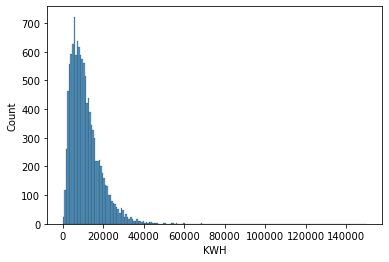

In [9]:
import seaborn as sns
sns.histplot(data=df, x="KWH")

With IQR method, there are only 3% of the data in column KWH are missing, so we can drop them

In [10]:
Q1 = df['KWH'].quantile(0.25)
Q3 = df['KWH'].quantile(0.75)
IQR = Q3 - Q1
((df['KWH'] < (Q1 - 1.5 * IQR)) | (df['KWH'] > (Q3 + 1.5 * IQR))).sum()/len(df)

0.0336064895290125

In [11]:
outlier = df[(df['KWH'] < (Q1 - 1.5 * IQR)) | (df['KWH'] > (Q3 + 1.5 * IQR))].index

In [12]:
df = df.drop(outlier)

## 1.3 drop variables that containing many NaN values
replace not applicable data to NaN

In [13]:
df.replace(-2, np.nan, inplace=True)

Some variables have most of the data missing, so we can consider removing them. By convention, we remove columns containing more than 60% NaN values, but for simplicity, I will remove columns containing more than 10%. 

In [14]:
((df.isnull().sum().sort_values(ascending=False)/len(df)))

AGEHHMEMCAT14    0.999657
AGEHHMEMCAT13    0.999657
AGEHHMEMCAT12    0.999486
AGEHHMEMCAT11    0.999058
AGEHHMEMCAT10    0.998544
                   ...   
ZTIMEON3         0.000000
ZPCONOFF3        0.000000
ZPCSLEEP3        0.000000
ZINTERNET        0.000000
DesignDBT1       0.000000
Length: 940, dtype: float64

Let's drop Dataframe columns containing either 10% or more than 10% NaN values

In [15]:
min_count =  int(((100-10)/100)*df.shape[0] + 1)
mod_df = df.dropna( axis=1, thresh=min_count)

In [16]:
((mod_df.isnull().sum().sort_values(ascending=False)/len(mod_df)))

STOVENFUEL       0.096360
ELECCHRG         0.090450
OUTLET           0.089936
THERMAIN         0.088737
HIGHCEIL         0.044797
                   ...   
ZTVAUDIOSYS3     0.000000
ZOTHERSTB3       0.000000
ZTVONWD3         0.000000
ZTVONWDWATCH3    0.000000
DesignDBT1       0.000000
Length: 652, dtype: float64

# 2. Data engineering/wrangling

In Data engineering part,
* we can define new variables (I didn't do it because I think the variables are sufficient and require expertise) 
* identify the variable types (eg. ordinal, categorical, numerical) for the preprocessing
* fix multicollinearity problem
* build pipeline for the feature transformation (eg. imputation, scaling, one-hot encoding)

I will use the dataset dictionary to filter out the redundent imputation flag variables

In [17]:
drop_imp_flag = df_dictionary[df_dictionary['Variable Description'].str.contains('Imputation flag')]['Variable Name'].to_list()
df_dictionary = df_dictionary.drop(df_dictionary[df_dictionary['Variable Name'].isin(drop_imp_flag)].index)

## 2.1 Multicollinearity

Multicolinearity is a problem because it can still mess with the coefficient estimates; These can be problematic from an inferential standpoint.
* For example, the variable KWHSPH is the electricity usage for space heating, in kilowatt-hours, and the variable BTUELSPH is the electricity usage for space heating, in thousand BTU. These are the same feature but just in different measurements. 

So, we drop the features with correlation greater than 0.95.

In [18]:
mod_df['KWH']

0        18466
1         5148
2         2218
3        10015
4         2869
         ...  
12078     7647
12079     1813
12080     9834
12081     4800
12082     1764
Name: KWH, Length: 11675, dtype: int64

In [19]:
# Create correlation matrix
corr_matrix = mod_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
drop_features = [column for column in upper.columns if any(upper[column] > 0.95)]
df_dictionary = df_dictionary.drop(df_dictionary[df_dictionary['Variable Name'].isin(drop_features)].index)

/var/folders/37/q5159fb14k90rc41kpn69yth0000gn/T/ipykernel_66335/2114081471.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


We keep track of the variables that we need to drop and store the variable names in drop_features

In [20]:
drop_features.extend(drop_imp_flag)

In [21]:
# DOEID is not a predictive variable, so remove it
drop_features.append('DOEID')

## 2.2 Identify the variable types

In [22]:
df_dictionary = df_dictionary[df_dictionary['Variable Name'].isin(mod_df.columns)]

In [23]:
# identify binary variables
binary_features = df_dictionary[df_dictionary['Variable Label'].str.contains('No\nYes')]['Variable Name'].to_list()
df_dictionary = df_dictionary.drop(df_dictionary[df_dictionary['Variable Name'].isin(binary_features)].index)

In [24]:
# identify numericc variables
numeric_features = df_dictionary[~df_dictionary["Variable Label"].str.contains('\n',regex=False)]['Variable Name'].to_list()
numeric_features = numeric_features+ ['TEMPHOME', 'TEMPGONE','TEMPNITE']
df_dictionary = df_dictionary.drop(df_dictionary[df_dictionary['Variable Name'].isin(numeric_features)].index)
numeric_features.remove('KWH')
numeric_features.remove('DOEID')

In [25]:
# manually identify the ordinal features.
ordinal_features = ['Climate_Region_Pub','AIA_Zone','YEARMADERANGE','OCCUPYYRANGE','SIZRFRI1','AGERFRI1','TVSIZE1','TVONWD1',
                   'TVONWE1','BATTOOLS','ELECDEV','EQUIPAGE','WHEATSIZ','WINDOWS','EDUCATION','MONEYPY','PERIODEL']
df_dictionary = df_dictionary.drop(df_dictionary[df_dictionary['Variable Name'].isin(ordinal_features)].index)

In [26]:
# identify categorical variables
categorical_features = df_dictionary['Variable Name'].to_list()

# No transformation variables
passthrough_features = binary_features + ordinal_features

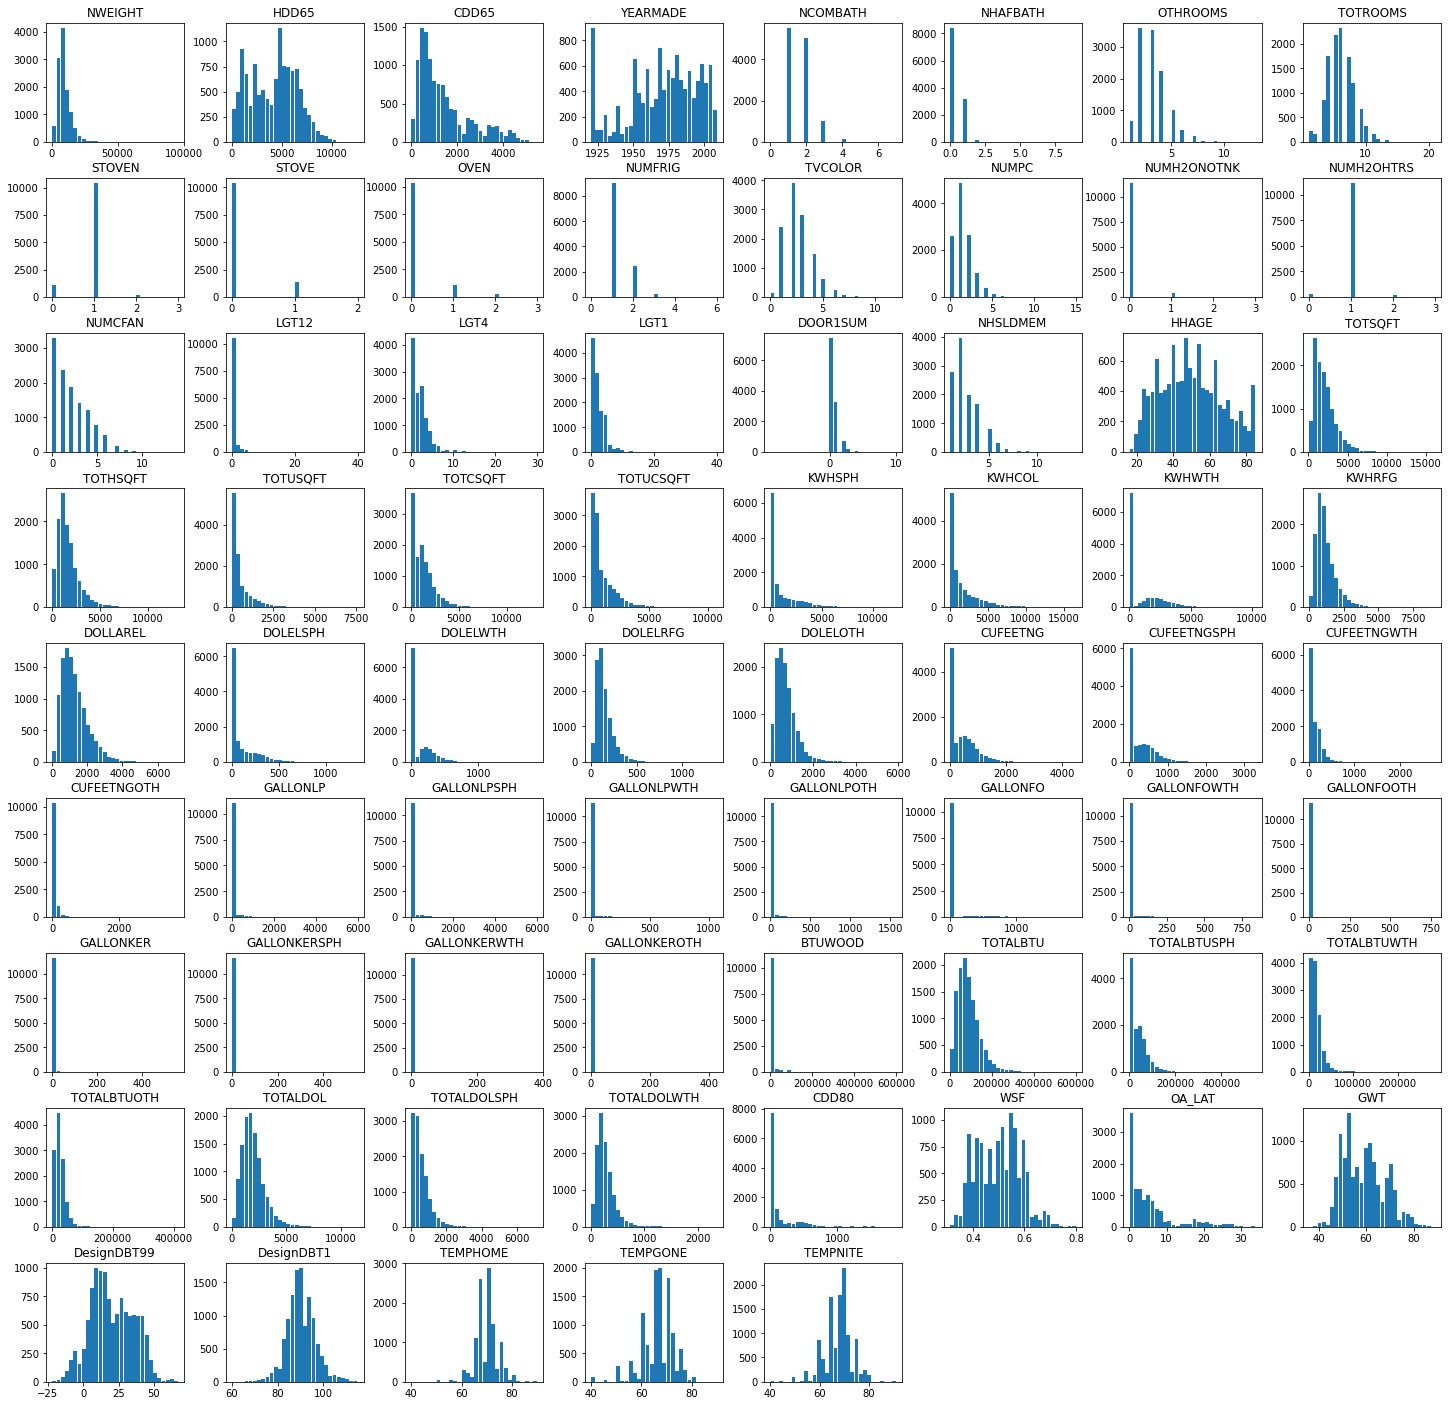

In [170]:
mod_df[numeric_features].hist(
    bins=30,
    figsize=(25, 25),
    grid = False,
    rwidth = 0.9,
)
plt.show()

split the data to training and testing
* Apply the transformations on training and testing sperately 
* If apply the transformation to the entire dataset, we might be allowing information from the testing set to leak into the training step.

In [30]:
train_df, test_df = train_test_split(mod_df, test_size=0.1, random_state=123)
X_train = train_df.drop(columns=['KWH'])
y_train = train_df["KWH"]

X_test = test_df.drop(columns=["KWH"])
y_test = test_df["KWH"]

## 2.3 Implement feature transformations such as imputation, scaling, and one-hot encoding in a machine learning model development pipeline
* I chose the simple imputer for the sake of time, and there are more advance way of imputing missing values.

In [31]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='median'), StandardScaler()),
        numeric_features,
    ),  # scaling on numeric features  
    (
        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown='ignore')), 
        categorical_features,
    ),  # OHE on categorical features
    (
        make_pipeline(SimpleImputer(strategy="most_frequent"), "passthrough"), 
        passthrough_features,
    ),  # no transformations on the binary and ordinal features
    ("drop", drop_features),
)

In [32]:
ct

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['NWEIGHT', 'HDD65', 'CDD65', 'YEARMADE',
                                  'NCOMBATH', 'NHAFBATH', 'OTHROOMS',
                                  'TOTROOMS', 'STOVEN', 'STOVE', 'OVEN',
                                  'NUMFRIG', 'TVCOLOR', 'NUMPC', 'NUMH2ONOTNK',
                                  'NUMH2OHTRS', 'NUMCFAN', 'LGT12', 'LGT4',
                                  'LGT1', 'DOOR1...
                                  'CDD30YR', 'YEARMADERANGE', 'ZGARGCOOL',
                                  'FUELFOOD', 'ZTYPERFR1', 'ZDVD3',
                                  'ZTVAUDIOSYS3', 'ZTVONWE3', 'ZRECBATH',
                                  'ELCOOL', 'FOWARM', 'KEROAUX', 'ZWDSCRAP',
                                  'ZWDPELLET', 'ZWDOTHER', 'ZAGEHHMEMCAT8',
                                  'ZAGEHHMEMCAT9', 'ZAGEHHMEMCAT11',
                                  'ZAGEHHMEMCAT12', 'ZAGEHHMEMCAT13',
                                  'ZAGEHHMEMCAT14', 'TOTSQFT_EN', 'ZTOTSQFT_EN',
                                  'ZTOTHSQFT', 'ZTOTUSQFT', 'ZTOTCSQFT',
                                  'ZTOTUCSQFT', ...])])

In [33]:
X_transformed = ct.fit_transform(X_train)

In [34]:
column_names = (
    numeric_features
    + ct.named_transformers_['pipeline-2']["onehotencoder"].get_feature_names_out(categorical_features).tolist()
    + passthrough_features
)

In [35]:
X_train_trans = pd.DataFrame(X_transformed, columns=column_names)
X_train_trans.head()

,NWEIGHT,HDD65,CDD65,YEARMADE,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,STOVEN,STOVE,...,TVONWD1,TVONWE1,BATTOOLS,ELECDEV,EQUIPAGE,WHEATSIZ,WINDOWS,EDUCATION,MONEYPY,PERIODEL
0,-0.743365,0.607711,-0.576574,-2.042174,0.504526,-0.597665,-0.105522,0.510899,0.259691,-0.358951,...,4.0,3.0,1.0,1.0,5.0,2.0,50.0,2.0,5.0,1.0
1,0.829607,0.299052,-0.657357,0.007090,0.504526,-0.597665,-0.105522,0.510899,-2.855123,2.740061,...,3.0,4.0,2.0,1.0,5.0,2.0,41.0,5.0,24.0,1.0
2,0.885316,0.293000,-0.401692,0.770542,0.504526,-0.597665,-0.105522,-0.432099,0.259691,-0.358951,...,3.0,4.0,0.0,1.0,42.0,3.0,30.0,3.0,15.0,1.0
3,1.023072,0.642295,-0.677775,0.770542,1.915506,-0.597665,2.855013,2.396893,0.259691,-0.358951,...,3.0,3.0,1.0,2.0,5.0,3.0,60.0,6.0,24.0,1.0
4,-0.421560,0.492288,-0.645817,-0.836724,-0.906454,-0.597665,-0.105522,0.039400,0.259691,-0.358951,...,3.0,3.0,1.0,1.0,3.0,2.0,41.0,5.0,22.0,1.0


# 3. Data analysis/Modeling

## 3.0. `Dummy Regressor`

In [71]:
scoring = ["neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error"]
dummy = make_pipeline(ct, DummyRegressor())
scores = cross_validate(dummy, X_train, y_train, cv=5, scoring=scoring,return_train_score=True)

pd.DataFrame(scores).mean()

fit_time                             2.054738e-01
score_time                           2.705331e-02
test_neg_mean_squared_error         -3.561183e+07
train_neg_mean_squared_error        -3.560149e+07
test_neg_mean_absolute_error        -4.834373e+03
train_neg_mean_absolute_error       -4.833729e+03
test_neg_root_mean_squared_error    -5.967104e+03
train_neg_root_mean_squared_error   -5.966670e+03
dtype: float64

## 3.1. `OLS regression`

In [156]:
from sklearn.linear_model import Ridge 
pipe_ols = make_pipeline(ct, Ridge(alpha=0))
ols_scores = cross_validate(pipe_ols, X_train, y_train, cv=5, scoring=scoring,return_train_score=True)
pd.DataFrame(ols_scores).mean()

fit_time                             1.284785e+00
score_time                           2.637177e-02
test_neg_mean_squared_error         -9.746607e+22
train_neg_mean_squared_error        -3.345866e+00
test_neg_mean_absolute_error        -7.498905e+09
train_neg_mean_absolute_error       -6.390731e-01
test_neg_root_mean_squared_error    -2.231792e+11
train_neg_root_mean_squared_error   -1.828771e+00
dtype: float64

### 1 Variable importance

In [168]:
pipe_ols = make_pipeline(
    ct,
    Ridge(alpha = 0 )
)
pipe_ols.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['NWEIGHT', 'HDD65', 'CDD65',
                                                   'YEARMADE', 'NCOMBATH',
                                                   'NHAFBATH', 'OTHROOMS',
                                                   'TOTROOMS', 'STOVEN',
                                                   'STOVE', 'OVEN', 'NUMFRIG',
                                                   'TVCOLOR', 'NUMPC',
                                                   'NUMH2ONOTNK', 'NUMH2OHTRS',
                                                   '...
                                                   'YEARMADERANGE', 'ZGARGCOOL',
                                                   'FUELFOOD', 'ZTYPERFR1',
                                                   'ZDVD3', 'ZTVAUDIOSYS3',
                                                   'ZTVONWE3', 'ZRECBATH',
                                                   'ELCOOL', 'FOWARM',
                                                   'KEROAUX', 'ZWDSCRAP',
                                                   'ZWDPELLET', 'ZWDOTHER',
                                                   'ZAGEHHMEMCAT8',
                                                   'ZAGEHHMEMCAT9',
                                                   'ZAGEHHMEMCAT11',
                                                   'ZAGEHHMEMCAT12',
                                                   'ZAGEHHMEMCAT13',
                                                   'ZAGEHHMEMCAT14',
                                                   'TOTSQFT_EN', 'ZTOTSQFT_EN',
                                                   'ZTOTHSQFT', 'ZTOTUSQFT',
                                                   'ZTOTCSQFT', 'ZTOTUCSQFT', ...])])),
                ('ridge', Ridge(alpha=0))])

In [169]:
data = {
    "coefficient": pipe_ols.named_steps["ridge"].coef_.tolist(),
    "magnitude": np.absolute(pipe_ols.named_steps["ridge"].coef_.tolist()),
}
coef_df = pd.DataFrame(data, index=X_train_trans.columns).sort_values(
    "magnitude", ascending=False
)
coef_df.head(15)

,coefficient,magnitude
FUELHEAT_8.0,-1.280934e+13,1.280934e+13
EMPLOYHH_2,1.176657e+13,1.176657e+13
EMPLOYHH_1,1.176657e+13,1.176657e+13
EMPLOYHH_0,1.176657e+13,1.176657e+13
USEEL,1.027105e+13,1.027105e+13
SOLWARM,1.019168e+13,1.019168e+13
SOLARAUX,-1.019168e+13,1.019168e+13
DRAFTY_3,7.173366e+12,7.173366e+12
DRAFTY_1,7.173366e+12,7.173366e+12
DRAFTY_4,7.173366e+12,7.173366e+12


## 3.2. `Ridge Regression`
### 1 deafult parameter

In [72]:
from sklearn.linear_model import Ridge 
pipe_ridge = make_pipeline(ct, Ridge())
ridge_scores = cross_validate(pipe_ridge, X_train, y_train, cv=5, scoring=scoring,return_train_score=True)
pd.DataFrame(ridge_scores).mean()

fit_time                              0.241467
score_time                            0.025771
test_neg_mean_squared_error         -31.802660
train_neg_mean_squared_error        -27.897999
test_neg_mean_absolute_error         -3.655607
train_neg_mean_absolute_error        -3.475433
test_neg_root_mean_squared_error     -5.634559
train_neg_root_mean_squared_error    -5.279839
dtype: float64

### 2 Hyperparameter optimization

In [110]:
param_grid = {
    "ridge__alpha": 10.0 ** np.arange(-5, 6, 1)
}

random_search = RandomizedSearchCV(
    pipe_ridge,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    random_state=123,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit=False,
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['NWEIGHT',
                                                                                'HDD65',
                                                                                'CDD65',
                                                                                'YEARMADE',
                                                                                'NCOMBATH',
                                                                                'NHAFBATH',
                                                                                'OTHROOMS',
                                                                                'TOTROOMS',
                                                                                'STOVEN',
                                                                                'STOVE',
                                                                                'OVEN',
                                                                                'NUMFRIG',
                                                                                'TVCOLOR',
                                                                                'N...
                                                                                'ZTOTHSQFT',
                                                                                'ZTOTUSQFT',
                                                                                'ZTOTCSQFT',
                                                                                'ZTOTUCSQFT', ...])])),
                                             ('ridge', Ridge())]),
                   n_jobs=-1,
                   param_distributions={'ridge__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
                   random_state=123, refit=False, return_train_score=True,
                   scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                            'neg_root_mean_squared_error'])

In [120]:
results = pd.DataFrame(random_search.cv_results_)[
    [
        'mean_test_neg_mean_squared_error',
        "mean_test_neg_root_mean_squared_error",
        'mean_test_neg_mean_absolute_error',
        "param_ridge__alpha",
        "mean_fit_time",
        "rank_test_neg_root_mean_squared_error",
    ]
].set_index('rank_test_neg_root_mean_squared_error').sort_index(ascending=True).T
results

rank_test_neg_root_mean_squared_error,1,2,3,4,5,6,7,8,9,10
mean_test_neg_mean_squared_error,-3.942028,-3.95508,-4.562815,-4.902187,-31.80266,-2076.189979,-67158.225104,-713793.056991,-4152265.661712,-16275165.65101
mean_test_neg_root_mean_squared_error,-1.979841,-1.983705,-2.132625,-2.211275,-5.634559,-45.507844,-258.954503,-844.569884,-2037.256945,-4033.489655
mean_test_neg_mean_absolute_error,-0.684472,-0.678497,-0.711211,-0.854939,-3.655607,-30.191808,-175.724484,-599.263795,-1514.716791,-3200.962008
param_ridge__alpha,0.00001,0.0001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0,100000.0
mean_fit_time,0.430591,0.357973,0.37628,0.471517,0.386929,0.361947,0.374145,0.37945,0.378473,0.340181


In [123]:
best_alpha_ridge = results[1].param_ridge__alpha

pipe_ridge = make_pipeline(
    ct,
    Ridge(alpha = best_alpha_ridge )
)

pipe_ridge.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['NWEIGHT', 'HDD65', 'CDD65',
                                                   'YEARMADE', 'NCOMBATH',
                                                   'NHAFBATH', 'OTHROOMS',
                                                   'TOTROOMS', 'STOVEN',
                                                   'STOVE', 'OVEN', 'NUMFRIG',
                                                   'TVCOLOR', 'NUMPC',
                                                   'NUMH2ONOTNK', 'NUMH2OHTRS',
                                                   '...
                                                   'YEARMADERANGE', 'ZGARGCOOL',
                                                   'FUELFOOD', 'ZTYPERFR1',
                                                   'ZDVD3', 'ZTVAUDIOSYS3',
                                                   'ZTVONWE3', 'ZRECBATH',
                                                   'ELCOOL', 'FOWARM',
                                                   'KEROAUX', 'ZWDSCRAP',
                                                   'ZWDPELLET', 'ZWDOTHER',
                                                   'ZAGEHHMEMCAT8',
                                                   'ZAGEHHMEMCAT9',
                                                   'ZAGEHHMEMCAT11',
                                                   'ZAGEHHMEMCAT12',
                                                   'ZAGEHHMEMCAT13',
                                                   'ZAGEHHMEMCAT14',
                                                   'TOTSQFT_EN', 'ZTOTSQFT_EN',
                                                   'ZTOTHSQFT', 'ZTOTUSQFT',
                                                   'ZTOTCSQFT', 'ZTOTUCSQFT', ...])])),
                ('ridge', Ridge(alpha=1e-05))])

### 3 Variable importance

In [124]:
data = {
    "coefficient": pipe_ridge.named_steps["ridge"].coef_.tolist(),
    "magnitude": np.absolute(pipe_ridge.named_steps["ridge"].coef_.tolist()),
}
coef_df = pd.DataFrame(data, index=X_train_trans.columns).sort_values(
    "magnitude", ascending=False
)
coef_df.head(15)

,coefficient,magnitude
TOTALBTUOTH,4282.502371,4282.502371
CUFEETNGOTH,-2830.936735,2830.936735
GALLONLP,-2695.115801,2695.115801
TOTALBTU,2295.680766,2295.680766
KWHCOL,1691.995011,1691.995011
GALLONLPSPH,1574.772982,1574.772982
CUFEETNG,-1328.628842,1328.628842
KWHSPH,1186.804347,1186.804347
KWHWTH,1128.697508,1128.697508
GALLONFO,-1081.948848,1081.948848


## 3.3 `Lasso`
### 1 deafault parameters

In [125]:
pipe_lasso = make_pipeline(ct, Lasso(max_iter=5000))
lasso_scores = cross_validate(pipe_lasso, X_train, y_train, cv=5, scoring=scoring,return_train_score=True)
pd.DataFrame(lasso_scores).mean()

fit_time                              1.460366
score_time                            0.027532
test_neg_mean_squared_error         -22.052144
train_neg_mean_squared_error        -20.741490
test_neg_mean_absolute_error         -3.116950
train_neg_mean_absolute_error        -3.102149
test_neg_root_mean_squared_error     -4.680359
train_neg_root_mean_squared_error    -4.553094
dtype: float64

### 2 Hyperparameter optimization

In [126]:
param_grid = {
    "lasso__alpha": 10.0 ** np.arange(-5, 6, 1)
}

random_search = RandomizedSearchCV(
    pipe_lasso,
    param_grid,
    n_iter=10,
    n_jobs=-1,
    random_state=123,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit=False
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['NWEIGHT',
                                                                                'HDD65',
                                                                                'CDD65',
                                                                                'YEARMADE',
                                                                                'NCOMBATH',
                                                                                'NHAFBATH',
                                                                                'OTHROOMS',
                                                                                'TOTROOMS',
                                                                                'STOVEN',
                                                                                'STOVE',
                                                                                'OVEN',
                                                                                'NUMFRIG',
                                                                                'TVCOLOR',
                                                                                'N...
                                                                                'ZTOTUSQFT',
                                                                                'ZTOTCSQFT',
                                                                                'ZTOTUCSQFT', ...])])),
                                             ('lasso', Lasso(max_iter=5000))]),
                   n_jobs=-1,
                   param_distributions={'lasso__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
                   random_state=123, refit=False, return_train_score=True,
                   scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                            'neg_root_mean_squared_error'])

In [127]:
results = pd.DataFrame(random_search.cv_results_)[
    [
        'mean_test_neg_mean_squared_error',
        "mean_test_neg_root_mean_squared_error",
        'mean_test_neg_mean_absolute_error',
        "param_lasso__alpha",
        "mean_fit_time",
        "rank_test_neg_root_mean_squared_error",
    ]
].set_index('rank_test_neg_root_mean_squared_error').sort_index(ascending=True).T
results

rank_test_neg_root_mean_squared_error,1,2,3,4,5,6,7,8,9,10
mean_test_neg_mean_squared_error,-22.052144,-25.82818,-162.041994,-196.871121,-198.929533,-2148.538749,-220768.212616,-6479746.945695,-33713436.67482,-35611831.627412
mean_test_neg_root_mean_squared_error,-4.680359,-4.972014,-12.260848,-13.52811,-13.628548,-46.262043,-469.08654,-2545.281053,-5805.811275,-5967.104364
mean_test_neg_mean_absolute_error,-3.11695,-2.303409,-5.267881,-5.984345,-6.001513,-32.229216,-326.258784,-1984.267499,-4699.468794,-4834.372579
param_lasso__alpha,1.0,0.1,0.01,0.0001,0.00001,10.0,100.0,1000.0,10000.0,100000.0
mean_fit_time,3.146008,3.446693,4.072669,4.547204,4.752054,0.608065,0.549632,0.392215,0.371318,0.348084


In [128]:

best_alpha_lasso = results[1].param_lasso__alpha

pipe_lasso = make_pipeline(
    ct,
    Lasso(max_iter=5000, alpha = best_alpha_lasso )
)

pipe_lasso.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['NWEIGHT', 'HDD65', 'CDD65',
                                                   'YEARMADE', 'NCOMBATH',
                                                   'NHAFBATH', 'OTHROOMS',
                                                   'TOTROOMS', 'STOVEN',
                                                   'STOVE', 'OVEN', 'NUMFRIG',
                                                   'TVCOLOR', 'NUMPC',
                                                   'NUMH2ONOTNK', 'NUMH2OHTRS',
                                                   '...
                                                   'YEARMADERANGE', 'ZGARGCOOL',
                                                   'FUELFOOD', 'ZTYPERFR1',
                                                   'ZDVD3', 'ZTVAUDIOSYS3',
                                                   'ZTVONWE3', 'ZRECBATH',
                                                   'ELCOOL', 'FOWARM',
                                                   'KEROAUX', 'ZWDSCRAP',
                                                   'ZWDPELLET', 'ZWDOTHER',
                                                   'ZAGEHHMEMCAT8',
                                                   'ZAGEHHMEMCAT9',
                                                   'ZAGEHHMEMCAT11',
                                                   'ZAGEHHMEMCAT12',
                                                   'ZAGEHHMEMCAT13',
                                                   'ZAGEHHMEMCAT14',
                                                   'TOTSQFT_EN', 'ZTOTSQFT_EN',
                                                   'ZTOTHSQFT', 'ZTOTUSQFT',
                                                   'ZTOTCSQFT', 'ZTOTUCSQFT', ...])])),
                ('lasso', Lasso(max_iter=5000))])

### 3 Variable importance

In [129]:
data = {
    "coefficient": pipe_lasso.named_steps["lasso"].coef_.tolist(),
    "magnitude": np.absolute(pipe_lasso.named_steps["lasso"].coef_.tolist()),
}
coef_df = pd.DataFrame(data, index=X_train_trans.columns).sort_values(
    "magnitude", ascending=False
)
coef_df.head(15)

,coefficient,magnitude
TOTALBTUOTH,5045.457212,5045.457212
CUFEETNGOTH,-3118.492937,3118.492937
KWHCOL,1995.382434,1995.382434
KWHWTH,1409.355286,1409.355286
KWHSPH,1397.462947,1397.462947
GALLONLPOTH,-1156.097479,1156.097479
KWHRFG,690.348698,690.348698
GALLONFOOTH,-600.129109,600.129109
GALLONKEROTH,-283.572028,283.572028
DOLLAREL,2.454304,2.454304


## 3.4. `Decision Tree`
### 1. default parameters

In [131]:
pipe_tree = make_pipeline(ct, DecisionTreeRegressor())
tree_scores = cross_validate(pipe_tree, X_train, y_train, cv=5, scoring=scoring,return_train_score=True)
pd.DataFrame(tree_scores).mean()

fit_time                             7.130817e-01
score_time                           2.573428e-02
test_neg_mean_squared_error         -3.988872e+06
train_neg_mean_squared_error         0.000000e+00
test_neg_mean_absolute_error        -1.292950e+03
train_neg_mean_absolute_error        0.000000e+00
test_neg_root_mean_squared_error    -1.996761e+03
train_neg_root_mean_squared_error    0.000000e+00
dtype: float64

### 2. hyperparameter optimization

In [48]:
tree_param_grid={"decisiontreeregressor__splitter":["best"],
            "decisiontreeregressor__max_depth" : [1,5,10,15,20,30,40,50,70,100],
           "decisiontreeregressor__min_samples_leaf":[2,4,5,6,8,9,10,15,20,25,30],
           "decisiontreeregressor__max_features":["log2","sqrt",None],
           "decisiontreeregressor__max_leaf_nodes":[300,400,500,700,800,1000,1200,2000,2500,3000,4000,4500,5000,6000,None] }

In [136]:
random_search = RandomizedSearchCV(
    pipe_tree,
    param_distributions=tree_param_grid,
    n_jobs=-1,
    n_iter=100,
    cv=5,
    scoring=scoring,
    refit=False,
    random_state=123,
    return_train_score=True
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['NWEIGHT',
                                                                                'HDD65',
                                                                                'CDD65',
                                                                                'YEARMADE',
                                                                                'NCOMBATH',
                                                                                'NHAFBATH',
                                                                                'OTHROOMS',
                                                                                'TOTROOMS',
                                                                                'STOVEN',
                                                                                'STOVE',
                                                                                'OVEN',
                                                                                'NUMFRIG',
                                                                                'TVCOLOR',
                                                                                'N...
                                        'decisiontreeregressor__max_leaf_nodes': [300,
                                                                                  400,
                                                                                  500,
                                                                                  700,
                                                                                  800,
                                                                                  1000,
                                                                                  1200,
                                                                                  2000,
                                                                                  2500,
                                                                                  3000,
                                                                                  4000,
                                                                                  4500,
                                                                                  5000,
                                                                                  6000,
                                                                                  None],
                                        'decisiontreeregressor__min_samples_leaf': [2,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                                    8,
                                                                                    9,
                                                                                    10,
                                                                                    15,
                                                              

In [137]:
results = pd.DataFrame(random_search.cv_results_)[
    [
        'mean_test_neg_mean_squared_error',
        "mean_test_neg_root_mean_squared_error",
        'mean_test_neg_mean_absolute_error',
        "mean_fit_time",
        "rank_test_neg_root_mean_squared_error",
        'param_decisiontreeregressor__splitter',
        'param_decisiontreeregressor__max_depth',
        'param_decisiontreeregressor__max_features',
        'param_decisiontreeregressor__min_samples_leaf',
        "param_decisiontreeregressor__max_leaf_nodes"

    ]
].set_index("rank_test_neg_root_mean_squared_error").sort_index(ascending=True).T
results

rank_test_neg_root_mean_squared_error,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mean_test_neg_mean_squared_error,-3298028.619938,-3298257.266304,-3299442.993721,-3310196.257711,-3330663.431254,-3333105.696775,-3335705.808601,-3348632.734399,-3350557.650662,-3383906.72342,...,-29763650.482016,-30236680.598536,-30636885.331798,-30837036.464919,-30910305.930171,-31017189.022809,-31223977.473506,-31706080.32057,-32241688.99387,-32519018.866476
mean_test_neg_root_mean_squared_error,-1815.425582,-1815.453524,-1815.817501,-1818.753767,-1824.537553,-1825.194911,-1825.894087,-1829.670728,-1830.152034,-1839.008993,...,-5452.243955,-5481.389899,-5527.008885,-5546.104878,-5558.455305,-5562.879532,-5583.959496,-5628.065324,-5675.563368,-5700.698146
mean_test_neg_mean_absolute_error,-1222.868657,-1222.232225,-1223.181873,-1231.289489,-1223.998304,-1223.838691,-1224.182263,-1238.67585,-1244.995986,-1255.574572,...,-4363.735341,-4412.951222,-4438.198678,-4461.224551,-4470.913752,-4461.980004,-4470.958165,-4511.422839,-4559.788164,-4588.467821
mean_fit_time,0.614835,0.711166,0.678854,0.644522,0.724359,0.678743,0.653028,0.693666,0.667214,0.494431,...,0.24968,0.292491,0.298466,0.277282,0.298192,0.261614,0.247509,0.244804,0.246336,0.269981
param_decisiontreeregressor__splitter,best,best,best,best,best,best,best,best,best,best,...,best,best,best,best,best,best,best,best,best,best
param_decisiontreeregressor__max_depth,30,15,100,100,40,40,15,40,70,40,...,1,1,1,1,1,1,1,1,1,1
param_decisiontreeregressor__max_features,None,None,None,None,None,None,None,None,None,None,...,log2,sqrt,log2,log2,log2,log2,log2,log2,log2,log2
param_decisiontreeregressor__min_samples_leaf,10,10,10,10,9,9,9,15,9,20,...,8,20,20,5,8,25,15,2,6,25
param_decisiontreeregressor__max_leaf_nodes,2500,1200,None,500,1000,2000,None,4000,400,None,...,2500,1200,500,4000,400,500,2000,2000,6000,4000


In [138]:
pipe_tree = make_pipeline(
    ct,
    DecisionTreeRegressor(splitter='best', min_samples_leaf = 10, max_leaf_nodes = 2500, 
                         max_features = None, max_depth = 30)
)

pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['NWEIGHT', 'HDD65', 'CDD65',
                                                   'YEARMADE', 'NCOMBATH',
                                                   'NHAFBATH', 'OTHROOMS',
                                                   'TOTROOMS', 'STOVEN',
                                                   'STOVE', 'OVEN', 'NUMFRIG',
                                                   'TVCOLOR', 'NUMPC',
                                                   'NUMH2ONOTNK', 'NUMH2OHTRS',
                                                   '...
                                                   'ELCOOL', 'FOWARM',
                                                   'KEROAUX', 'ZWDSCRAP',
                                                   'ZWDPELLET', 'ZWDOTHER',
                                                   'ZAGEHHMEMCAT8',
                                                   'ZAGEHHMEMCAT9',
                                                   'ZAGEHHMEMCAT11',
                                                   'ZAGEHHMEMCAT12',
                                                   'ZAGEHHMEMCAT13',
                                                   'ZAGEHHMEMCAT14',
                                                   'TOTSQFT_EN', 'ZTOTSQFT_EN',
                                                   'ZTOTHSQFT', 'ZTOTUSQFT',
                                                   'ZTOTCSQFT', 'ZTOTUCSQFT', ...])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=30, max_leaf_nodes=2500,
                                       min_samples_leaf=10))])

### 3. Variable importance

In [139]:
data = {
    "Importance":pipe_tree.named_steps["decisiontreeregressor"].feature_importances_,
}
imps = pd.DataFrame(
    data=data,
    index=X_train_trans.columns,
)
imps.sort_values(by="Importance", ascending=False)[:15]

,Importance
DOLLAREL,0.777270
REGIONC_1,0.057225
TOTALBTU,0.036164
KWHSPH,0.023473
HDD65,0.016874
TOTALBTUOTH,0.015236
KWHCOL,0.011565
FUELH2O_5.0,0.010470
KWHWTH,0.010429
CUFEETNGOTH,0.005155


## 3.5. Random Forest
### 1 deafault parameters

This is computationally expensive, and it takes hours to run! I will pass random forest

In [140]:
# rf = RandomForestRegressor(random_state=123)
# rf_scores = cross_validate(rf, X_train_trans, y_train, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
# pd.DataFrame(rf_scores).mean()

### 2 Hyperparameter optimization

In [141]:
# rf_param_grid = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': [None, 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [142]:
# rf = RandomForestRegressor(random_state=123)
# random_search = RandomizedSearchCV(
#     rf,
#     param_distributions=rf_param_grid,
#     n_jobs=-1,
#     n_iter=3,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     refit=False,
#     random_state=123,
#     return_train_score=True
# )
# random_search.fit(X_train_trans, y_train)

In [143]:
# pd.DataFrame(random_search.cv_results_)[
#     [
#         "mean_test_score",
#         'mean_train_score',
#         "mean_fit_time",
#         "rank_test_score",
#         'param_bootstrap',
#         'param_max_depth',
#         'param_max_features',
#         'param_min_samples_leaf',
#         'param_min_samples_split',
#         'param_n_estimators',

#     ]
# ].set_index('rank_test_score').sort_index(ascending=True).T

In [144]:
# random_search.best_params_

In [145]:
# rf = RandomForestRegressor(random_state=123, **random_search.best_params_)
# rf.fit(X_train_trans, y_train)

### 3 Variable importance

In [146]:
# data = {
#     "Importance": rf.feature_importances_,
# }
# imps = pd.DataFrame(
#     data=data,
#     index=X_train_trans.columns,
# )
# imps.sort_values(by="Importance", ascending=False)[:15]

## 3.6. `Voting ensemble`

To make the model more generalizable to unseen data, I will add this ensemble model.

In [147]:
from sklearn.ensemble import VotingRegressor
models = {
    "ridge": pipe_ridge,
    "lasso": pipe_lasso
}

In [148]:
averaging_model = VotingRegressor(list(models.items()))
averaging_model.fit(X_train, y_train)

VotingRegressor(estimators=[('ridge',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['NWEIGHT',
                                                                                'HDD65',
                                                                                'CDD65',
                                                                                'YEARMADE',
                                                                                'NCOMBATH',
                                                                                'NHAFBATH',
                                                                                'OTHROOMS',
                                                                                'TOTROOMS',
                                                                                'STOVEN',
                                                                                'STOVE',
                                                                                'OVEN',
                                                                                'NUMFRIG',
                                                                                'TVCOLOR'...
                                                                                'FUELFOOD',
                                                                                'ZTYPERFR1',
                                                                                'ZDVD3',
                                                                                'ZTVAUDIOSYS3',
                                                                                'ZTVONWE3',
                                                                                'ZRECBATH',
                                                                                'ELCOOL',
                                                                                'FOWARM',
                                                                                'KEROAUX',
                                                                                'ZWDSCRAP',
                                                                                'ZWDPELLET',
                                                                                'ZWDOTHER',
                                                                                'ZAGEHHMEMCAT8',
                                                                                'ZAGEHHMEMCAT9',
                                                                                'ZAGEHHMEMCAT11',
                                                                                'ZAGEHHMEMCAT12',
                                                                                'ZAGEHHMEMCAT13',
                                                                                'ZAGEHHMEMCAT14',
                                                                                'TOTSQFT_EN',
                                                                                'ZTOTSQFT_EN',
                                                                                'ZTOTHSQFT',
                                                                                'ZTOTUSQFT',
                                                                                'ZTO

In [149]:
averaging_scores = cross_validate(averaging_model, X_train, y_train, cv=5, scoring=scoring,return_train_score=True)
pd.DataFrame(averaging_scores).mean()

fit_time                             1.701040
score_time                           0.050438
test_neg_mean_squared_error         -8.369994
train_neg_mean_squared_error        -7.704072
test_neg_mean_absolute_error        -1.707324
train_neg_mean_absolute_error       -1.689089
test_neg_root_mean_squared_error    -2.882597
train_neg_root_mean_squared_error   -2.775216
dtype: float64

# 5. Data evaluation/validation

In [154]:
data = {'ml':[], "model":[], "test_rmse":[]}
data["ml"].append('ridge')
data["ml"].append('lasso')
data["ml"].append('voting ensemble')

data["model"].append('ridge')
data["model"].append('lasso')
data["model"].append(['ridge','lasso'])

data["test_rmse"].append(sqrt(mean_squared_error(y_test, pipe_ridge.predict(X_test))))
data["test_rmse"].append(sqrt(mean_squared_error(y_test, pipe_lasso.predict(X_test))))
data["test_rmse"].append(sqrt(mean_squared_error(y_test, averaging_model.predict(X_test))))

Seems like ridge is performing the best with lowest mse. Therefore I would choose ridge model

In [155]:
pd.DataFrame(data)

,ml,model,test_rmse
0,ridge,ridge,2.079414
1,lasso,lasso,4.556611
2,voting ensemble,"[ridge, lasso]",2.908476


# 6. Analysis write-up

From the variable importance sections: 

* The variable TOTALBTUOTH seem to be the most important and influential variable. This make sense because the total usage for appliances, electronics, lighting, and miscellaneous uses should be the major electricity consumptions
* There are interesting findings that natural gas (CUFEETNGOTH), fuel oil (GALLONFO) propane (GALLONLPOTH) usages have a negative relationship with KWH. That means, if the household use more gas, fuel or propane then they are more likely to use less electricity. This means that these energies are alternative options for the households to live.
* The other variables are expected to be in the model, such as the electricity usage for different kind of purposes. 

Future work:

* collecting seasonal electricity usage might be useful for predicting KWH.
* training some more complex models might also be useful (eg. random forest, xgboost)
* using some advance imputing missing value method could also be helpful

In conclusion:
* Ridge regression did a great job predicting KWH with RMSE around 2.0. This is simple model, fast to train, and easy to interpret. 
